# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[100]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[150]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[490]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.
This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy i

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.
This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy i

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This dog toy has been a huge hit at my house. I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into. This toy is hard enough to hold up but not so hard he loses interest. The irregular shapes are great for giving him multiple chew spots on this toy. This dinosaur has even brought out the puppy in my 8yr old mix that was never big on chew toys.<br />Ca not go wrong with this one!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This dog toy has been a huge hit at my house I just added a bulldog puppy to my family and if he is awake his teeth are constantly seeking something to sink into This toy is hard enough to hold up but not so hard he loses interest The irregular shapes are great for giving him multiple chew spots on this toy This dinosaur has even brought out the puppy in my 8yr old mix that was never big on chew toys br Ca not go wrong with this one 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:57<00:00, 1516.23it/s]


In [23]:
preprocessed_reviews[150]

'dog toy huge hit house added bulldog puppy family awake teeth constantly seeking something sink toy hard enough hold not hard loses interest irregular shapes great giving multiple chew spots toy dinosaur even brought puppy old mix never big chew toys ca not go wrong one'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

In [25]:
final['clean_text']=preprocessed_reviews

In [26]:
final['clean_text'].head(5)

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
Name: clean_text, dtype: object

In [27]:
final=final.sort_values('Time',ascending=True)

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaawwwwwwwwww']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (160176, 75601)
the number of unique words  75601


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (160176, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abide', 'abilities']


KeyboardInterrupt: 

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [29]:
%%time
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)# y_train
final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_train))
print("the shape of out text BOW vectorizer ",final_counts_x_train.get_shape())
print("the number of unique words ", final_counts_x_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (52663, 49074)
the number of unique words  49074
Wall time: 7.17 s


In [30]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    mb = MultinomialNB(alpha = i)
    mb.fit(final_counts_x_train, y_tr)
    
    
    pred = mb.predict_proba(final_counts_x_train)[:,1]
    auc_tr = roc_auc_score(y_tr, pred)
    print("AUC score for alpha", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
print('*'*50, '\n')


AUC score for alpha 1e-05 is  0.9814239589391935
AUC score for alpha 0.0001 is  0.9808962663860569
AUC score for alpha 0.001 is  0.9798021118030975
AUC score for alpha 0.01 is  0.9773351135245258
AUC score for alpha 0.1 is  0.9710950534720357
AUC score for alpha 10 is  0.7180090611927114
AUC score for alpha 100 is  0.5472088182135026
AUC score for alpha 1000 is  0.5138690726186523
AUC score for alpha 10000 is  0.4773779977915803
************************************************** 

Wall time: 979 ms


In [31]:
print(auc_tr)

[0.9814239589391935, 0.9808962663860569, 0.9798021118030975, 0.9773351135245258, 0.9710950534720357, 0.7180090611927114, 0.5472088182135026, 0.5138690726186523, 0.4773779977915803]


In [32]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc

auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    mb = MultinomialNB(alpha = i)
    mb.fit(final_counts_x_train, y_tr)
    
    
    pred = mb.predict_proba(final_counts_x_crossval)[:,1]
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for alpha", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score_cv]
print('*'*50, '\n')


AUC score for alpha 1e-05 is  0.8085127763775015
AUC score for alpha 0.0001 is  0.8317043241363345
AUC score for alpha 0.001 is  0.8594411093688292
AUC score for alpha 0.01 is  0.8889123824697789
AUC score for alpha 0.1 is  0.9126837127268287
AUC score for alpha 10 is  0.7034278854962591
AUC score for alpha 100 is  0.5482707100997859
AUC score for alpha 1000 is  0.5165397431436493
AUC score for alpha 10000 is  0.4795752928070248
************************************************** 

Wall time: 607 ms


In [33]:
print(auc_cv)

[0.8085127763775015, 0.8317043241363345, 0.8594411093688292, 0.8889123824697789, 0.9126837127268287, 0.7034278854962591, 0.5482707100997859, 0.5165397431436493, 0.4795752928070248]


Text(0.5,1,'alpha values v/s AUC')

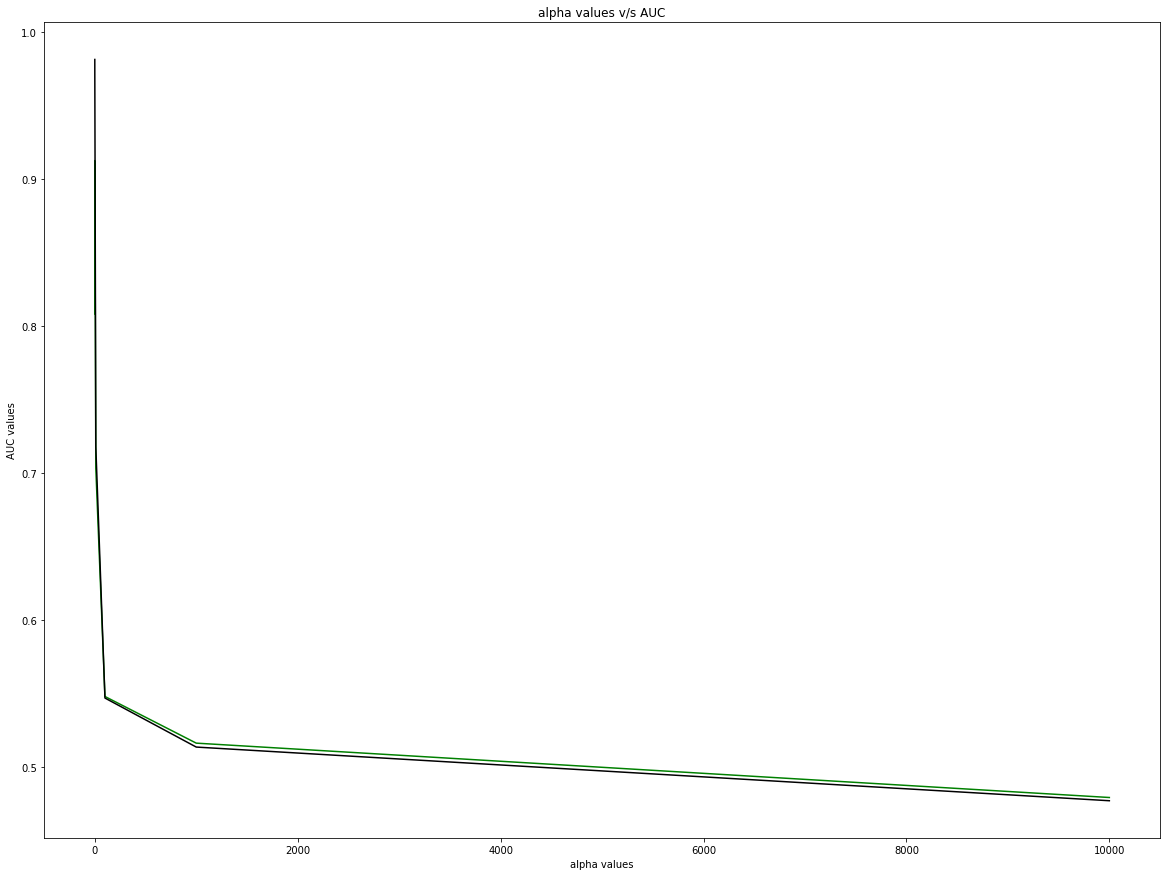

In [34]:

plt.figure(figsize = (20,15))
plt.plot(a, auc_cv,color='green')




plt.plot(a, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("alpha values v/s AUC")
#plt.xticks(np.arange(0,10,0.01))
#plt.yticks(np.arange(0,10,0.02))

In [35]:
best_alpha1=0.01

In [36]:
mb = MultinomialNB(alpha =  best_alpha1)
mb.fit(final_counts_x_train, y_tr)
prediction = mb.predict_proba(final_counts_x_test)[:,1]

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.8719896017881545


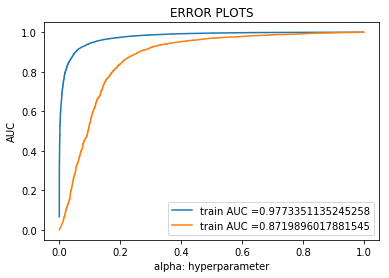

Train confusion matrix
[[ 6739  1286]
 [ 1502 43136]]
Test confusion matrix
[[ 1841  1073]
 [  796 13845]]


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


mb = MultinomialNB(alpha = best_alpha1)
mb_train=mb.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, mb.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, mb.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, mb.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, mb.predict(final_counts_x_test))
print(confusion_matrix(y_test, mb.predict(final_counts_x_test)))


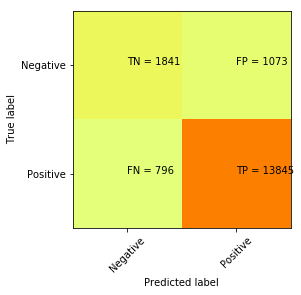

In [39]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [40]:
list_of_features=count_vect.get_feature_names()

In [41]:
print(mb_train.feature_log_prob_)

[[-11.65694452 -17.36405478 -17.36405478 ... -12.74893427 -17.36405478
  -17.36405478]
 [-12.05263194 -12.96742529 -13.25427645 ... -18.96138671 -14.3462662
  -14.3462662 ]]


In [42]:
features=pd.DataFrame(mb_train.feature_log_prob_,columns=list_of_features)

In [43]:
features_transpose=features.T
features_transpose.head()

,0,1
aa,-11.656945,-12.052632
aaa,-17.364055,-12.967425
aaaa,-17.364055,-13.254276
aaaaa,-17.364055,-14.346266
aaaaaaaaaaaa,-17.364055,-18.961387


In [44]:
# Please write all the code with proper documentation

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [45]:
# Please write all the code with proper documentation
positive_features=features_transpose[0].sort_values(ascending=False)
top10_positive_features=positive_features[:10]

In [46]:
print(top10_positive_features)

not       -3.286718
like      -4.371342
would     -4.624414
taste     -4.679263
product   -4.711692
one       -4.839888
good      -5.081480
coffee    -5.120682
flavor    -5.161985
no        -5.168533
Name: 0, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [47]:
# Please write all the code with proper documentation
negative_features=features_transpose[1].sort_values(ascending=False)
top10_negative_features=negative_features[:10]

In [48]:
print(top10_negative_features)

not      -3.715900
like     -4.528045
good     -4.658093
great    -4.746093
one      -4.869988
taste    -4.973941
tea      -5.054664
flavor   -5.081868
would    -5.082900
love     -5.088078
Name: 1, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [49]:
%%time
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almonds']
Wall time: 6.58 s


In [50]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    mb = MultinomialNB(alpha = i)
    mb.fit(final_tf_idf_tr, y_tr)
    
    
    pred = mb.predict_proba(final_tf_idf_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred)
    print("AUC score for alpha", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)


auc_score_tr = [x for x in auc_score_tr]
print('*'*50, '\n')


AUC score for alpha 1e-05 is  0.8903817752193868
AUC score for alpha 0.0001 is  0.890381778010968
AUC score for alpha 0.001 is  0.8903817780109677
AUC score for alpha 0.01 is  0.890382224663925
AUC score for alpha 0.1 is  0.8903786765644961
AUC score for alpha 10 is  0.8873449035990317
AUC score for alpha 100 is  0.8219903888658351
AUC score for alpha 1000 is  0.6618508712314877
AUC score for alpha 10000 is  0.5946589546450443
************************************************** 

Wall time: 623 ms


In [51]:
print(auc_score_tr)

[0.8903817752193868, 0.890381778010968, 0.8903817780109677, 0.890382224663925, 0.8903786765644961, 0.8873449035990317, 0.8219903888658351, 0.6618508712314877, 0.5946589546450443]


In [52]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc

auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    mb = MultinomialNB(alpha = i)
    mb.fit(final_tf_idf_tr, y_tr)
    
    
    pred = mb.predict_proba(final_tf_idf_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for alpha", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score_cv]
print('*'*50, '\n')

AUC score for alpha 1e-05 is  0.8830515978515582
AUC score for alpha 0.0001 is  0.883051705603802
AUC score for alpha 0.001 is  0.8830516840533532
AUC score for alpha 0.01 is  0.8830555200332325
AUC score for alpha 0.1 is  0.8830881043117578
AUC score for alpha 10 is  0.8827460340385891
AUC score for alpha 100 is  0.824461229083296
AUC score for alpha 1000 is  0.6677676144424729
AUC score for alpha 10000 is  0.5992412604202346
************************************************** 

Wall time: 372 ms


In [53]:
print(auc_cv)

[0.8830515978515582, 0.883051705603802, 0.8830516840533532, 0.8830555200332325, 0.8830881043117578, 0.8827460340385891, 0.824461229083296, 0.6677676144424729, 0.5992412604202346]


Text(0.5,1,'alpha values v/s AUC')

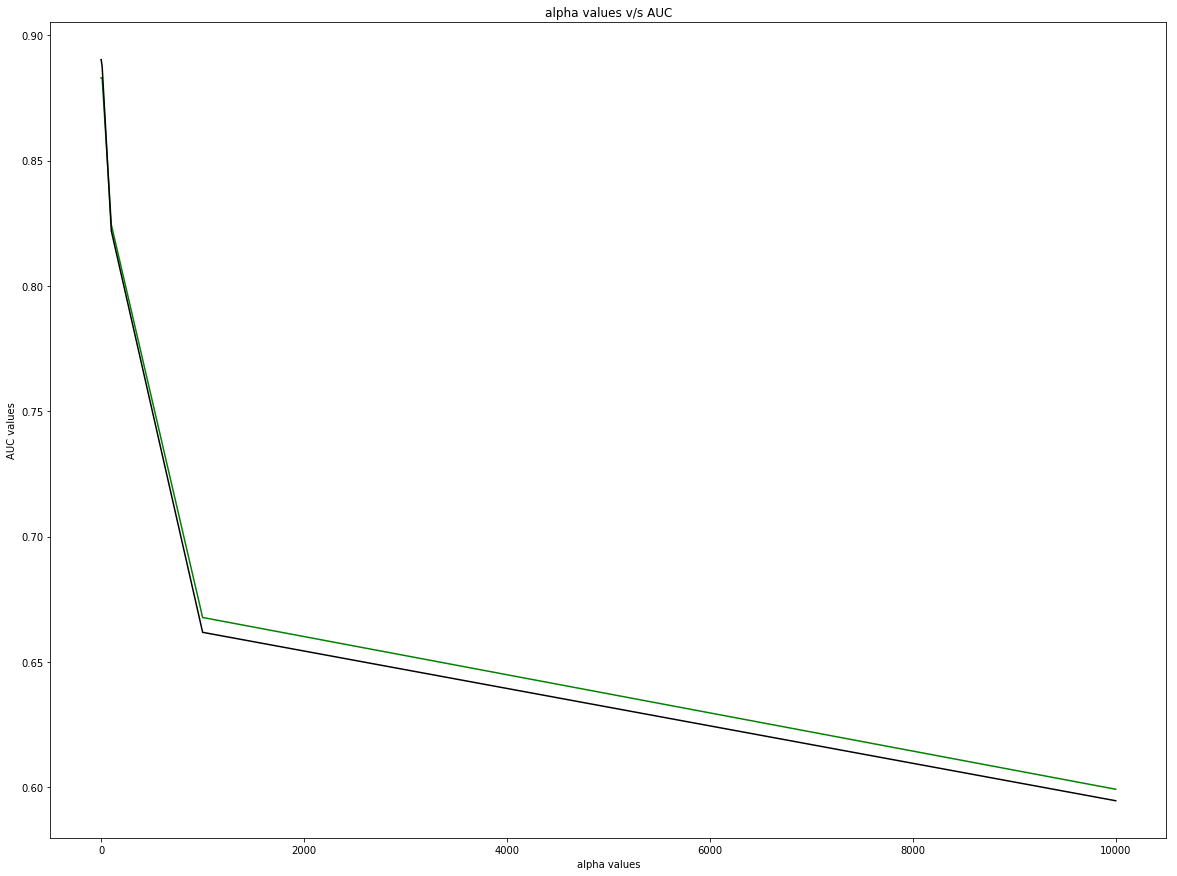

In [54]:

plt.figure(figsize = (20,15))
plt.plot(a, auc_cv,color='green')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("alpha values v/s AUC")
#plt.xticks(np.arange(0,10,0.01))
#plt.yticks(np.arange(0,10,0.02))

In [55]:
best_alpha2=0.1

In [56]:
mb = MultinomialNB(alpha =best_alpha2)
mb.fit(final_tf_idf_tr, y_tr)
prediction = mb.predict_proba(final_tf_idf_test)[:,1]

In [57]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.885276405044699


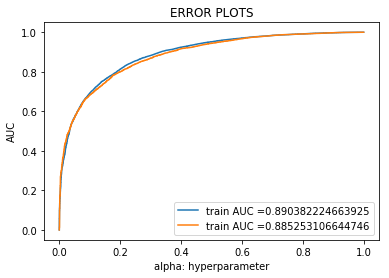

Train confusion matrix
[[  165  7860]
 [    7 44631]]
Test confusion matrix
[[   64  2850]
 [    5 14636]]


In [58]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


mb = MultinomialNB(alpha = best_alpha1)
mb_train=mb.fit(final_tf_idf_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, mb.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, mb.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, mb.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, mb.predict(final_tf_idf_test))
print(confusion_matrix(y_test, mb.predict(final_tf_idf_test)))


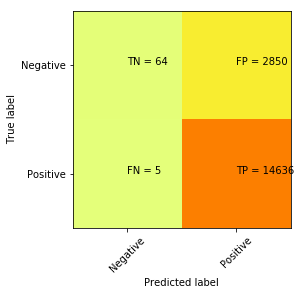

In [59]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [60]:
list_of_features1=tf_idf_vect.get_feature_names()

In [61]:
print(mb_train.feature_log_prob_[:10])

[[-6.91848238 -6.81803659 -6.91436282 -6.10685307 -6.56631337 -6.43352125
  -7.2628906  -6.33053147 -6.66253599 -7.77204238 -5.93503802 -5.62641329
  -7.48847292 -6.61843126 -6.70783984 -8.20393237 -5.06079546 -6.50418351
  -5.99420861 -6.48021224 -5.98414405 -7.199898   -6.98633878 -6.41801499
  -6.13183663 -6.37639904 -6.87988637 -7.01058869 -5.46647242 -8.3656354
  -6.42741557 -5.61355282 -5.08495323 -5.54638161 -5.91168937 -6.37819171
  -6.0592203  -6.45113549 -6.83283613 -6.46496483 -6.25245378 -5.327873
  -6.18168422 -6.27735573 -6.72036133 -6.05070733 -6.50826019 -6.80205831
  -7.45239988 -6.07990537 -5.15876329 -7.22454123 -5.12282467 -6.0122
  -5.66609255 -6.62806371 -7.30899238 -7.37326105 -7.24581823 -6.84114496
  -6.77973273 -4.96113516 -5.82259255 -6.71970918 -6.22208105 -6.3633723
  -7.06347017 -6.4316349  -5.90308823 -6.5758912  -6.18528394 -6.32615224
  -6.45932617 -6.28894032 -6.74560285 -6.25779365 -6.9019871  -6.63862291
  -6.17094607 -6.10728003 -5.30224475 -7.36765

  -6.69346058 -6.57804037]]


In [62]:
features1=pd.DataFrame(mb_train.feature_log_prob_,columns=list_of_features1)

In [63]:
features_transpose1=features.T
features_transpose1.head()

,0,1
aa,-11.656945,-12.052632
aaa,-17.364055,-12.967425
aaaa,-17.364055,-13.254276
aaaaa,-17.364055,-14.346266
aaaaaaaaaaaa,-17.364055,-18.961387


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [64]:
# Please write all the code with proper documentation
positive_features=features_transpose[0].sort_values(ascending=False)
top10_positive_features=positive_features[:10]

In [65]:
print(top10_positive_features)

not       -3.286718
like      -4.371342
would     -4.624414
taste     -4.679263
product   -4.711692
one       -4.839888
good      -5.081480
coffee    -5.120682
flavor    -5.161985
no        -5.168533
Name: 0, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [66]:
# Please write all the code with proper documentation
negative_features=features_transpose[1].sort_values(ascending=False)
top10_negative_features=negative_features[:10]

In [67]:
print(top10_negative_features)

not      -3.715900
like     -4.528045
good     -4.658093
great    -4.746093
one      -4.869988
taste    -4.973941
tea      -5.054664
flavor   -5.081868
would    -5.082900
love     -5.088078
Name: 1, dtype: float64


# [6] Conclusions

In [70]:
# Please compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S.No", "Featurization", "alpha","auc scores"]

x.add_row([1,"Bag of Words",0.01,87.19])
x.add_row([2,"Tf-Idf",0.1,88.52])


In [71]:
print(x)

+------+---------------+-------+------------+
| S.No | Featurization | alpha | auc scores |
+------+---------------+-------+------------+
|  1   |  Bag of Words |  0.01 |   87.19    |
|  2   |     Tf-Idf    |  0.1  |   88.52    |
+------+---------------+-------+------------+
